# Current implementation of a Brownian Motion Simulation

This short script covers the task regarding the prediction as well as correlation factors of the token prices of BTC, ETH & LUNA

In [51]:
import pandas
import requests
import matplotlib.pyplot as plt
import numpy as np
from binance.client import Client

In [2]:
# get historice OHLC data from Kraken CEX
eth = requests.get('https://api.kraken.com/0/public/OHLC?pair=ETHUSD&interval=1440&since=1638831600').json()['result']

luna = requests.get('https://api.kraken.com/0/public/OHLC?pair=LUNAUSD&interval=1440&since=1638831600').json()['result']

btc = requests.get('https://api.kraken.com/0/public/OHLC?pair=BTCUSD&interval=1440&since=1638831600').json()['result']

luna_df = pandas.DataFrame(luna['LUNAUSD'], columns=['ts', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])
eth_df = pandas.DataFrame(eth['XETHZUSD'], columns=['ts', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])
btc_df = pandas.DataFrame(btc['XXBTZUSD'], columns=['ts', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])


In [ ]:
# get historice OHLC data from Binance CEX
client=Client()

eth_df=pd.DataFrame(client.get_historical_klines(symbol='ETHUSD',start_str='2021-12-07',interval='1d'))

btc_df=pd.DataFrame(client.get_historical_klines(symbol='BTCUSD',start_str='2021-12-07',interval='1d'))

luna_df=pd.DataFrame(client.get_historical_klines(symbol='LUNAUSD',start_str='2021-12-07',interval='1d'))

eth_df = eth_df[['open', 'high', 'low', 'close']]

btc_df = btc_df[['open', 'high', 'low', 'close']]

luna_df = luna_df[['open', 'high', 'low', 'close']]


In [3]:
class Brownian():
    def __init__(self,x0=0):
        """
        Init class
        """
        assert (type(x0)==float or type(x0)==int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
    
    def gen_normal(self,n_step=100):
        """
        Generate motion by drawing from the Normal distribution
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def stock_price(
                    self,
                    s0=100,
                    mu=0.2,
                    sigma=1,
                    deltaT=52,
                    dt=0.1
                    ):
        """
        Models a stock price S(t) using the Weiner process W(t) as
        `S(t) = S(0).exp{(mu-(sigma^2/2).t)+sigma.W(t)}`
        
        Arguments:
            s0: Iniital stock price, default 100
            mu: 'Drift' of the stock (upwards or downwards), default 1
            sigma: 'Volatility' of the stock, default 1
            deltaT: The time period for which the future prices are computed, default 52 (as in 52 weeks)
            dt (optional): The granularity of the time-period, default 0.1
        
        Returns:
            s: A NumPy array with the simulated stock prices over the time-period deltaT
        """
        n_step = int(deltaT/dt)
        time_vector = np.linspace(0,deltaT,num=n_step)
        # Stock variation
        stock_var = (mu-(sigma**2/2))*time_vector
        # Forcefully set the initial value to zero for the stock price simulation
        self.x0=0
        # Weiner process (calls the `gen_normal` method)
        weiner_process = sigma*self.gen_normal(n_step)
        # Add two time series, take exponent, and multiply by the initial stock price
        s = s0*(np.exp(stock_var+weiner_process))
        
        return s


In [86]:
# get incremental value-add on daily basis to assessment movement in either way, normalize for comparability
luna_df['diff'] = (luna_df['close'].astype(float)-luna_df['open'].astype(float))/luna_df['close'].astype(float).mean()
eth_df['diff'] = (eth_df['close'].astype(float)-eth_df['open'].astype(float))/eth_df['close'].astype(float).mean()
btc_df['diff'] = (btc_df['close'].astype(float)-btc_df['open'].astype(float))/btc_df['close'].astype(float).mean()

In [96]:
# get means & volatilities for either token for Wiener process
mus = []
sigma = []
for df in [luna_df, eth_df, btc_df]:
    #mus.append(df['close'].astype(float).mean()/df['close'].astype(float).max())
    #print(df['close'].astype(float).mean(), float(df.tail(1)['close'].iloc[0]))
    #mus.append((float(df.tail(1)['close'].iloc[0])-df['close'].astype(float).mean())/float(df.tail(1)['close'].iloc[0]))
    mus.append(df['diff'].mean())
    sigma.append(df['diff'].std())
print(mus)
print(sigma)

[0.0020193092194723907, -0.0060851735173442995, -0.0029930521847400878]
[0.07127194552175556, 0.04120337300091746, 0.03415128502538824]


LUNA boasts the strongest mean, coming with the caveat of having the highest volatility (double of peer group).

[0.0020193092194723907, -0.0060851735173442995, -0.0029930521847400878]
[0.07127194552175556, 0.04120337300091746, 0.03415128502538824]
0.0020193092194723907 0.07127194552175556
-0.0060851735173442995 0.04120337300091746
-0.0029930521847400878 0.03415128502538824


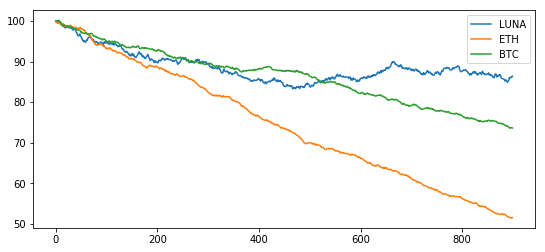

In [97]:
# run simulation
samples = Brownian()
plt.figure(figsize=(9,4))
for mu_sample, sigma_sample in zip(mus,sigma):
        print(mu_sample, sigma_sample)
        plt.plot(samples.stock_price(
                    mu=mu_sample,
                    sigma=sigma_sample,
                    deltaT=90,
                    dt=0.25))
plt.legend(['LUNA', 'ETH', 'BTC'])
plt.show()

After having covered price predictions, onto correlations

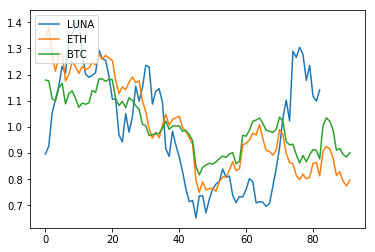

In [92]:
# get a first look at how normalized price curves look like
plt.figure()
plt.plot(luna_df['close'].astype(float)/luna_df['close'].astype(float).mean())
plt.plot(eth_df['close'].astype(float)/eth_df['close'].astype(float).mean())
plt.plot(btc_df['close'].astype(float)/btc_df['close'].astype(float).mean())
plt.legend(['LUNA', 'ETH', 'BTC'],
       loc='lower left')
plt.show()

In [99]:
# copy relevant data to compare incremental value-add over time
corr_check = pandas.DataFrame()
corr_check['luna'] = luna_df['diff']
corr_check['eth'] = eth_df['diff']
corr_check['btc'] = btc_df['diff']

In [105]:
# as overall correlation between tokens might not be as informative, we split the past 90 days into 10 days intervals
# to track market movements in a bit more detail
lunaeth=[]
lunabtc=[]
ethbtc=[]
for times in range(0,70,10):
    corr_check_temp = corr_check[times:times+10]
    lunaeth.append(corr_check_temp.corr()['luna']['eth'])
    lunabtc.append(corr_check_temp.corr()['luna']['btc'])
    ethbtc.append(corr_check_temp.corr()['eth']['btc'])
print(lunaeth)
print(lunabtc)
print(ethbtc)

[0.011926876310709857, 0.20847768645403328, -0.06715287758015215, -0.18672186284063857, 0.25274914757797207, -0.07196424228299511, 0.21629043426812272]
[0.1659716214474071, 0.23308477878340791, -0.30254070351385176, -0.3072529432463623, 0.12527439476387597, 0.11856528503183258, 0.11793873605744033]
[0.8805690394836864, 0.8106589315153716, 0.9050277265508858, 0.8652106471881998, 0.9463940649179042, 0.9208849213744263, 0.835235552605476]


In [1]:
# plotting the results show a high correlation between ETH-BTC but not so much for either with LUNA. The reason for
# this might be the higher volatility in the first place of LUNA over time (nearly double of ETH & BTC).
for temp in [lunaeth, lunabtc, ethbtc]:
    plt.plot(temp)
plt.legend(['LUNA-ETH', 'LUNA-BTC', 'ETH-BTC'])
plt.show()

NameError: name 'lunaeth' is not defined